In [281]:
import argparse
import datetime
from ray import tune
import os
import torch
import pickle
import copy
from tqdm import tqdm, trange

from marltoolbox.algos.alternating_offers.alt_offers_training import AltOffersTraining, run_episode
from marltoolbox.utils import miscellaneous, log

In [156]:
import json
import time
import argparse
import os
import datetime
from os import path
import numpy as np
import torch
from torch import autograd, optim, nn
from collections import defaultdict
from torch.autograd import Variable
import torch.nn.functional as F

import marltoolbox.algos.alternating_offers.nets as nets
import marltoolbox.algos.alternating_offers.logging_utils as logging_utils
from marltoolbox.algos.alternating_offers.envs.alt_offers_env import AltOffersEnv, AltOffersEnvMemory, calc_rewards
from marltoolbox.algos.alternating_offers.envs.alt_offers_env_sieve import SievePlayback

from ray import tune

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("darkgrid")

In [168]:
# root_path = '/home/alex_grig_lyzhov/ray_results/cross_play_debug/2021_03_18/18_33_25'
# checkpoint_dir_name = 'checkpoint_4'

root_path = '/home/alex_grig_lyzhov/ray_results/cross_play_20K_episodes/2021_03_18/22_47_17'
checkpoint_dir_name = 'checkpoint_312'  # for 20K episodes

In [169]:
default_cond_params = {'utilities_skew': 0, 'prosociality_level': 0.3, 'hidden_embedding_size': 30, 'fairness_coeff': 0}
default_i = None

In [170]:
trial_info = []
for i, trial_name in enumerate(os.listdir(root_path)):
    trial_path = os.path.join(root_path, trial_name)
    if os.path.isdir(trial_path):
        cur_trial_info = {}
        cur_trial_info['params'] = pickle.load(open(os.path.join(trial_path, 'params.pkl'), 'rb'))
        model_path = os.path.join(trial_path, checkpoint_dir_name, 'model.pth')
#         print(model_path)
        with open(model_path, 'rb') as f:
            state = torch.load(f)
        cur_trial_info['agents'] = []
        for i in range(2):
            cur_trial_info['agents'].append(state['agent%s' % i]['model_state'])
        trial_info.append(cur_trial_info)
        
        if cur_trial_info['params']['cond_params'] == default_cond_params:
            default_i = i

In [171]:
len(trial_info)

104

In [172]:
default_i

1

In [191]:
# {(trial['params']['match_mode'], trial['params']['cond_params']): trial['agents'] for trial in trial_info}

In [344]:
matches = {}
matches['custom_vs_custom_1'] = [trial for trial in trial_info if (trial['params']['match_mode'] == 'custom_vs_custom_1')]
matches['custom_vs_custom_2'] = [trial for trial in trial_info if (trial['params']['match_mode'] == 'custom_vs_custom_2')]
# matches['default_vs_custom'] = [trial for trial in trial_info if (trial['params']['match_mode'] == 'default_vs_custom')]
# matches['custom_vs_default'] = [trial for trial in trial_info if (trial['params']['match_mode'] == 'custom_vs_default')]

# this is reverse of what is should be, so correction:
matches['default_vs_custom'] = [trial for trial in trial_info if (trial['params']['match_mode'] == 'custom_vs_default')]
matches['custom_vs_default'] = [trial for trial in trial_info if (trial['params']['match_mode'] == 'default_vs_custom')]

In [345]:
matches['default_vs_default'] = [trial_info[default_i],] * len(matches['custom_vs_custom_1'])

In [346]:
def cond_params_iter():
    yield default_cond_params  # default parameters
    
    for utilities_skew in np.arange(-1, 1.1, 0.4):
        cur_params = copy.deepcopy(default_cond_params)
        cur_params['utilities_skew'] = utilities_skew
        yield cur_params
        
    for fairness_coeff in np.arange(0.0, 0.7, 0.1):
        cur_params = copy.deepcopy(default_cond_params)
        cur_params['fairness_coeff'] = fairness_coeff
        yield cur_params
        
    for prosociality_level in np.arange(0, 1.1, 0.2):
        cur_params = copy.deepcopy(default_cond_params)
        cur_params['prosociality_level'] = prosociality_level
        yield cur_params
        
    for hidden_embedding_size in [5, 10, 20, 40, 80, 160]:
        cur_params = copy.deepcopy(default_cond_params)
        cur_params['hidden_embedding_size'] = hidden_embedding_size
        yield cur_params
        
cond_params_list = list(cond_params_iter())

In [347]:
match_indices = defaultdict(list)
for match_regime, match_trials in matches.items():
    if match_regime == 'default_vs_default':
        match_indices['default_vs_default'] = range(len(matches['default_vs_default']))
    else:
        for cond_params_i, cond_params in enumerate(cond_params_list):
            eq_list = [(i, trial) for (i, trial) in enumerate(match_trials) if trial['params']['cond_params'] == cond_params]
            ind = eq_list[0][0]
            match_indices[match_regime].append(ind)

In [263]:
# matches['custom_vs_custom_1'][match_indices['custom_vs_custom_1'][5]]['params']['cond_params']

In [264]:
# matches['custom_vs_custom_2'][match_indices['custom_vs_custom_2'][5]]['params']['cond_params']

In [282]:
# agent_0_match_regime, agent_1_match_regime = ('default_vs_custom', 'custom_vs_custom_1')

In [374]:
# results = defaultdict(list)

In [375]:
# for agent_0_match_regime, agent_1_match_regime in (('custom_vs_custom_1', 'custom_vs_custom_1'),  # normal eval
#                                                    ('custom_vs_custom_1', 'custom_vs_custom_2'),   # simplest (1)
#                                                    ('default_vs_custom', 'custom_vs_custom_1'),   # 3.1
#                                                    ('custom_vs_custom_1', 'default_vs_custom'),):  # 4.1
for agent_0_match_regime, agent_1_match_regime in (
#                                                    ('custom_vs_custom_1', 'custom_vs_custom_1'),  # normal eval
#                                                    ('custom_vs_custom_1', 'custom_vs_custom_2'),   # simplest (1)
                                                   
#                                                    ('custom_vs_custom_1', 'default_vs_default'),  # 2.1
#                                                    ('default_vs_default', 'custom_vs_custom_1'),   # 2.2
                                                   
#                                                    ('default_vs_custom', 'custom_vs_custom_1'),   # 3.1
#                                                    ('custom_vs_custom_1', 'default_vs_custom'),  # 4.1
    
#                                                    ('default_vs_default', 'default_vs_custom'),   # 3.2
                                                   ('default_vs_custom', 'default_vs_default'),
                                                  ):  # 4.2
    for cond_params_i in trange(len(cond_params_list)):
        trial_0_i = match_indices[agent_0_match_regime][cond_params_i]
        trial_1_i = match_indices[agent_1_match_regime][cond_params_i]
        trial_0 = matches[agent_0_match_regime][trial_0_i]
        trial_1 = matches[agent_1_match_regime][trial_1_i]

        if agent_0_match_regime.split('_vs_')[0] == 'default':
            agent_0_params = default_cond_params
        else:
            agent_0_params = trial_0['params']['cond_params']
        if agent_1_match_regime.split('_vs_')[1] == 'default':
            agent_1_params = default_cond_params
        else:
            agent_1_params = trial_1['params']['cond_params']

        eval_episodes = 256
        # TODO load all other params from both configs
        config = {
            'name': 'cross_play_eval',
            'batch_size': 128,
            'training_episodes': eval_episodes,

            'enable_arbitrator': False,
            'scale_before_redist': True,

            'response_entropy_reg': 0.05,
            'utterance_entropy_reg': 1e-3,
            'proposal_entropy_reg': 0.05,
            'arbitrator_entropy_reg': None,
            'arbitrator_main_loss_coeff': None,

            'train_seed': None,
            'enable_cuda': False,
            'episodes_per_step': 64,
            'suppress_output': True,

            'agents_sgd': False,
            'arbitrator_sgd': False,
            'share_utilities': False,
            'enable_overflow': False,

            'enable_binding_comm': False,
            'enable_cheap_comm': True,
            'hidden_embedding_sizes': [agent_0_params['hidden_embedding_size'],
                                       agent_1_params['hidden_embedding_size']],
            'utility_types': [f"skew_{agent_0_params['utilities_skew']:.1f}",
                              f"skew_{agent_1_params['utilities_skew']:.1f}"],
            'prosociality_levels': [agent_0_params['prosociality_level'],
                                    agent_1_params['prosociality_level']],
            'fairness_coeffs': [agent_0_params['fairness_coeff'],
                                agent_1_params['fairness_coeff']],
        }

        alt_offers = AltOffersTraining(config)
        alt_offers.agent_models[0].load_state_dict(trial_0['agents'][0])
        alt_offers.agent_models[1].load_state_dict(trial_1['agents'][1])

        all_rewards = []
    #     for i in range(128):
        for i in range(64):
            env_state = AltOffersEnv(batch_size=alt_offers.args['batch_size'], random_state=alt_offers.train_random_state,
                                 utility_types=alt_offers.args['utility_types'])
            action_logprobs, entropy_loss_by_agent, arb_logprobs_accum, arb_entropy_loss, rewards, num_turns, alive_masks, \
            new_agent_forward_stats, new_arb_forward_stats = run_episode(
                args=alt_offers.args,
                env_state=env_state,
                agent_models=alt_offers.agent_models,
                arbitrator_model=alt_offers.arbitrator_model if alt_offers.args['enable_arbitrator'] else None,
                render_flag=False,
                deterministic=False,
            )
            all_rewards.append(rewards['sum_share_of_max'].numpy())
        welfare = np.concatenate(all_rewards, axis=0).mean()
#         print(agent_0_match_regime, agent_1_match_regime)
#         print(trial_0['params']['cond_params'])
#         print(welfare)
#         print()
        results[(agent_0_match_regime, agent_1_match_regime)].append(welfare)

100%|██████████| 26/26 [01:36<00:00,  3.72s/it]


In [ ]:
def cond_params_iter():
    yield default_cond_params  # default parameters
    
    for utilities_skew in np.arange(-1, 1.1, 0.4):
        cur_params = copy.deepcopy(default_cond_params)
        cur_params['utilities_skew'] = utilities_skew
        yield cur_params
        
    for fairness_coeff in np.arange(0.0, 0.7, 0.1):
        cur_params = copy.deepcopy(default_cond_params)
        cur_params['fairness_coeff'] = fairness_coeff
        yield cur_params
        
    for prosociality_level in np.arange(0, 1.1, 0.2):
        cur_params = copy.deepcopy(default_cond_params)
        cur_params['prosociality_level'] = prosociality_level
        yield cur_params
        
    for hidden_embedding_size in [5, 10, 20, 40, 80, 160]:
        cur_params = copy.deepcopy(default_cond_params)
        cur_params['hidden_embedding_size'] = hidden_embedding_size
        yield cur_params
        
cond_params_list = list(cond_params_iter())

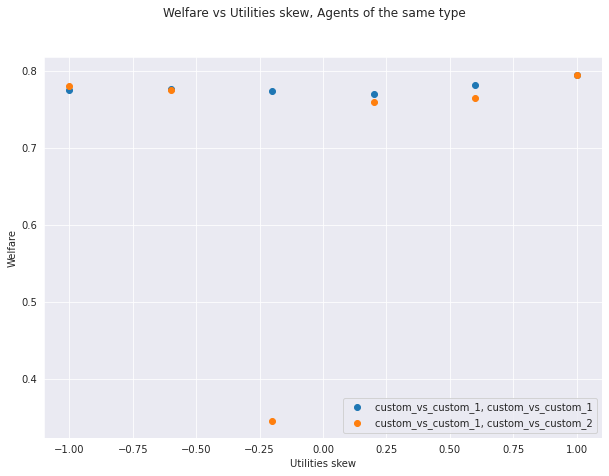

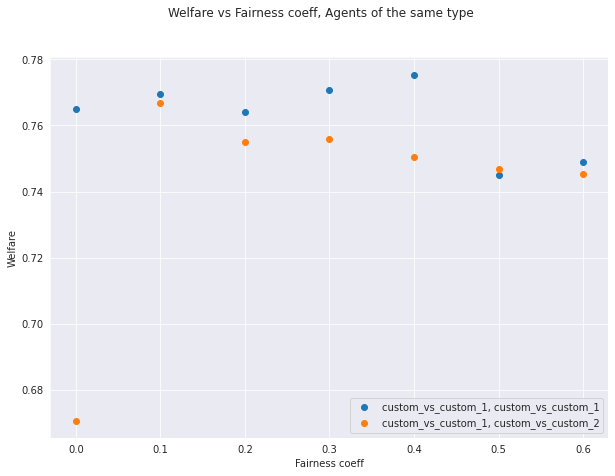

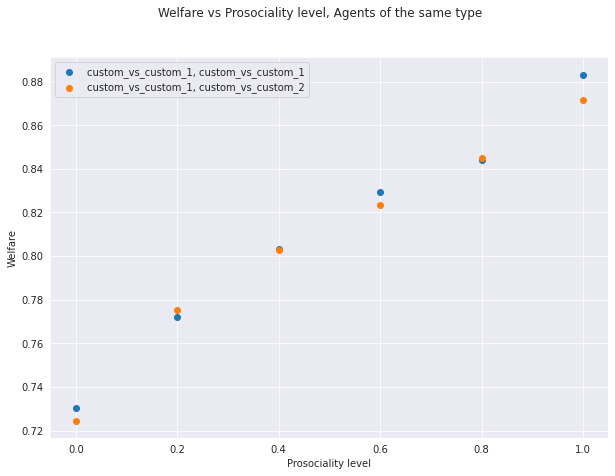

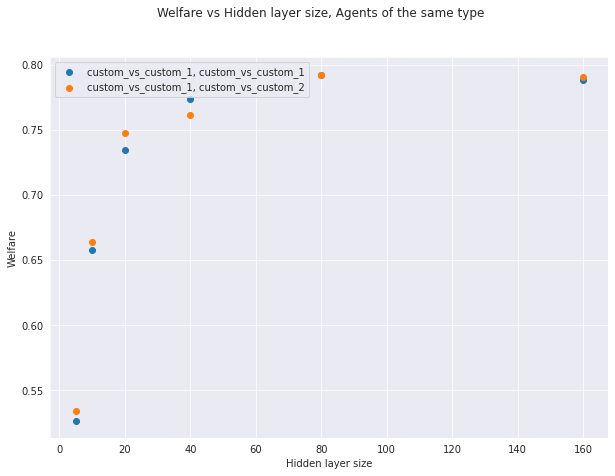

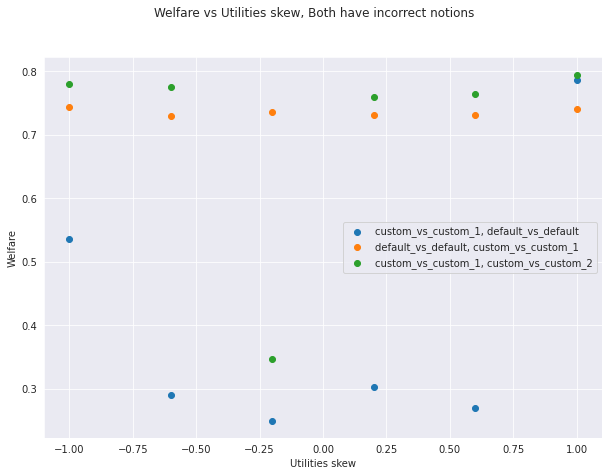

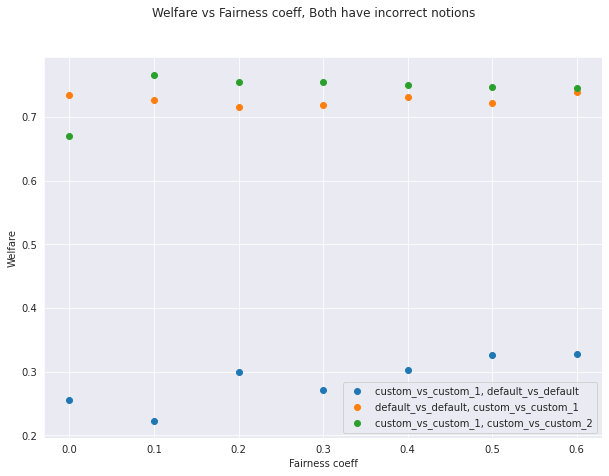

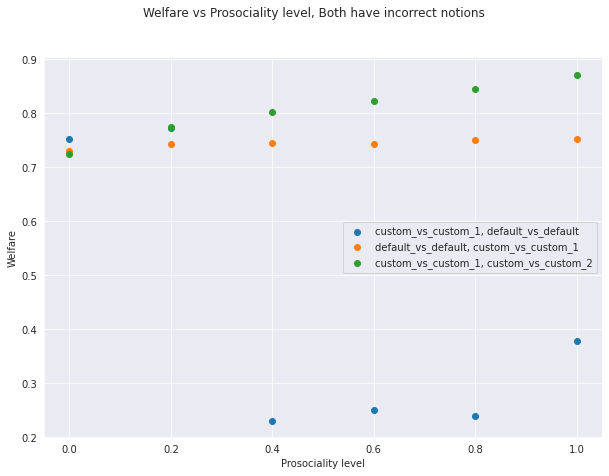

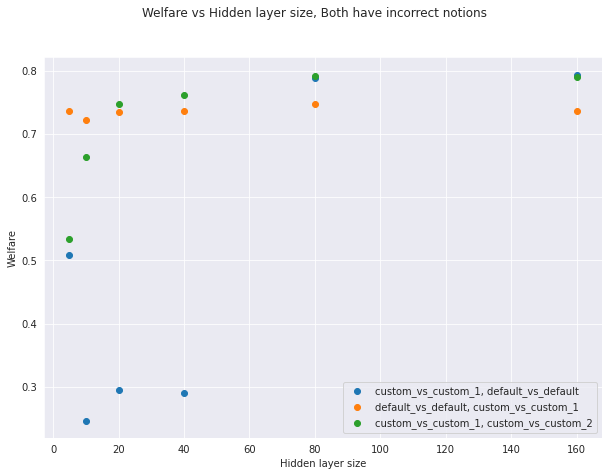

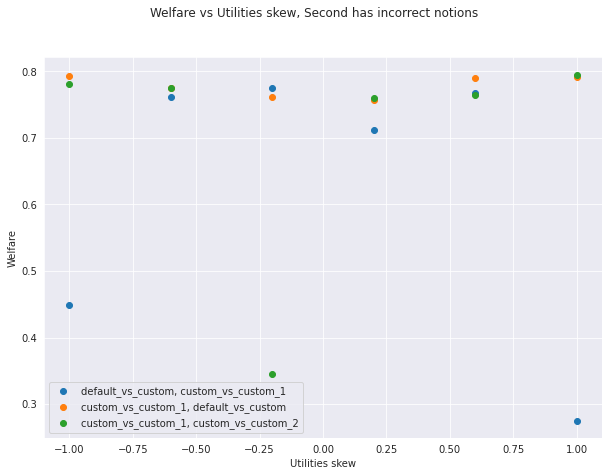

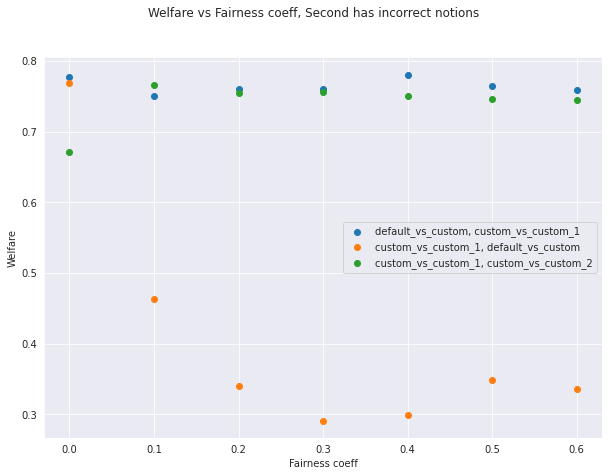

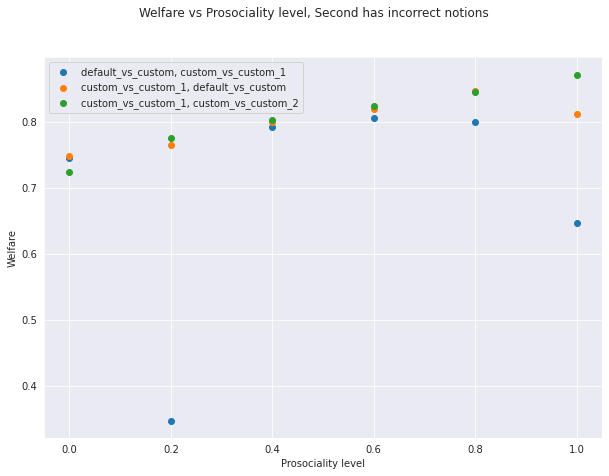

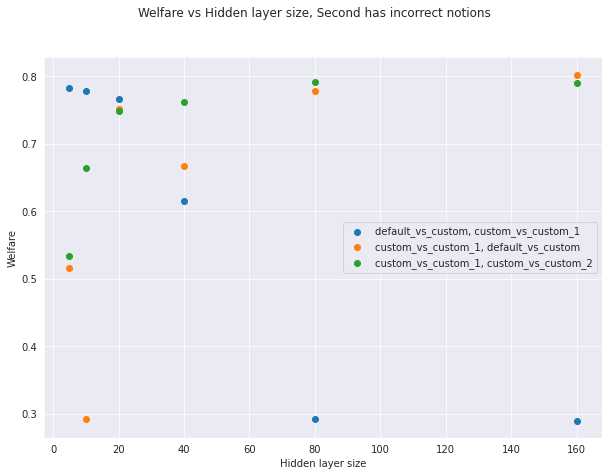

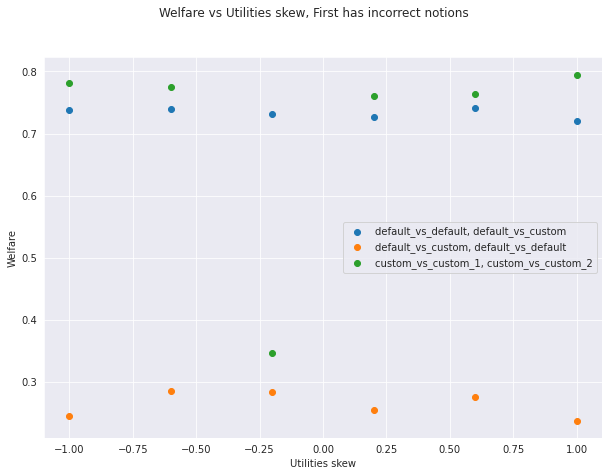

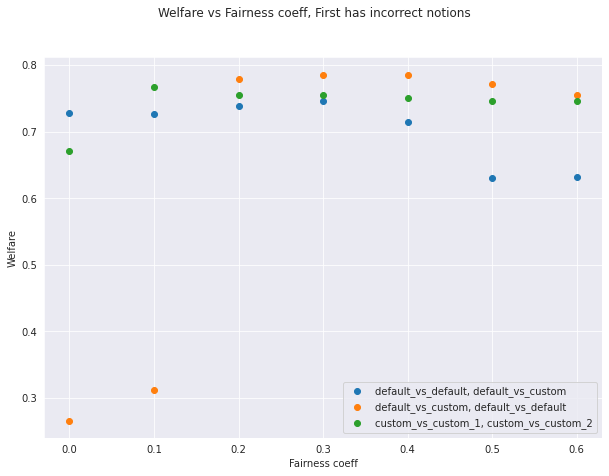

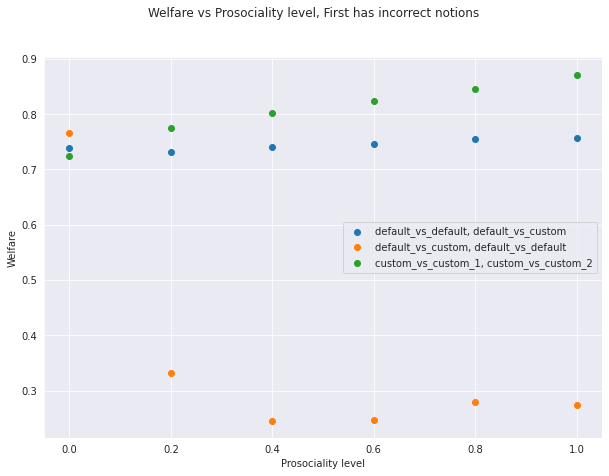

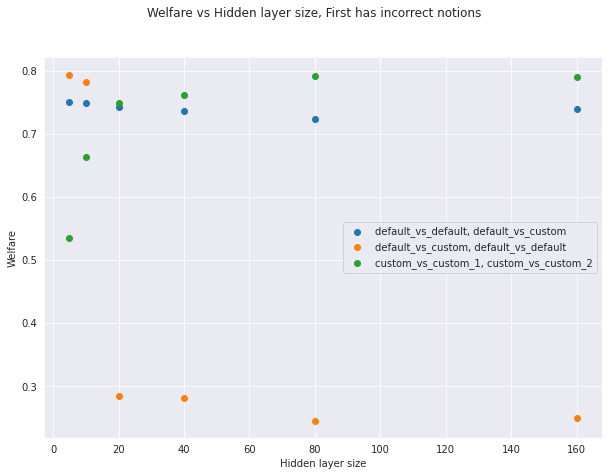

In [377]:
for eval_regime_name, eval_regime_list in [
    ('Agents of the same type', 
        (('custom_vs_custom_1', 'custom_vs_custom_1'),  # normal eval
        ('custom_vs_custom_1', 'custom_vs_custom_2'),)   # simplest (1)
    ),
    ('Both have incorrect notions',
        (
           ('custom_vs_custom_1', 'default_vs_default'),  # 2.1
           ('default_vs_default', 'custom_vs_custom_1'),   # 2.2
           ('custom_vs_custom_1', 'custom_vs_custom_2'),  # as baseline
        ),
    ),
    ('Second has incorrect notions',
        (
           ('default_vs_custom', 'custom_vs_custom_1'),   # 3.1
           ('custom_vs_custom_1', 'default_vs_custom'),  # 4.1
           ('custom_vs_custom_1', 'custom_vs_custom_2'),  # as baseline
        ),
    ),
    ('First has incorrect notions',
        (
           ('default_vs_default', 'default_vs_custom'),   # 3.2
           ('default_vs_custom', 'default_vs_default'),  # 4.2
           ('custom_vs_custom_1', 'custom_vs_custom_2'),  # as baseline
        ),
    ),
]:
    for xlabel, xarray, yarray in [
        ('Utilities skew', np.arange(-1, 1.1, 0.4), np.arange(1, 7)),
        ('Fairness coeff', np.arange(0.0, 0.7, 0.1), np.arange(7, 14)),
        ('Prosociality level', np.arange(0, 1.1, 0.2), np.arange(14, 20)),
        ('Hidden layer size', [5, 10, 20, 40, 80, 160], np.arange(20, 26))
    ]:
        plt.figure(figsize=(10, 7))
        for agent_0_match_regime, agent_1_match_regime in eval_regime_list:
            plt.scatter(xarray, np.array(results[(agent_0_match_regime, agent_1_match_regime)])[yarray],
                        label=f'{agent_0_match_regime}, {agent_1_match_regime}')
            plt.ylabel('Welfare')
            plt.xlabel(xlabel)
            plt.suptitle(f'Welfare vs {xlabel}, {eval_regime_name}')
            plt.legend()